In [ ]:
import os
import pandas as pd
import openai
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv
import tiktoken
import ast
import json
from langchain_core.output_parsers import JsonOutputParser

load_dotenv()
openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
# 1. 載入TCFD第四層揭露指引 (定義標準 labels)
excel_path = "data/tcfd第四層揭露指引.xlsx"
df_labels = pd.read_excel(excel_path).dropna(subset=['Label', 'Definition'])
# 建立 label 與 definition 的映射字典
label_mapping = dict(zip(df_labels['Label'], df_labels['Definition']))

In [3]:
label_mapping

{'G-1-1_1': '公司是否描述向董事會和/或董事會下設委員會，定期報告氣候相關風險與機會之流程？',
 'G-1-1_2': '公司是否描述向董事會和/或董事會下設委員會，報告氣候相關風險與機會之頻率？',
 'G-1-2_3': '公司是否描述董事會和/或董事會下設委員會，在監督和指導策略、重要行動計畫、風險管理政策、年度預算和營業計畫、公司的營業目標、計畫實施和執行情況時，考量氣候相關風險與機會？',
 'G-1-2_4': '公司是否描述董事會和/或董事會下設委員會，在監督重要資本支出、企業收購和撤資時，考量氣候相關風險與機會？',
 'G-1-3_5': '公司是否描述董事會或其所屬和/或指派之委員會如何監督風險與機會目標之實現？',
 'G-2-1_6': '公司是否描述已分派氣候相關責任給管理職位或委員會？',
 'G-2-1_7': '公司是否描述該管理職位或委員會向董事會或董事會下設委員會進行報告？',
 'G-2-1_8': '公司是否描述已分派之職責包含評估和/或管理氣候相關風險與機會？',
 'G-2-2_9': '公司是否有對氣候相關組織結構之描述？',
 'G-2-2_10': '公司是否描述有跨部門之氣候相關工作小組統籌執行相關工作？',
 'G-2-3_11': '公司是否描述執行管理階層掌握氣候相關風險與機會之流程？',
 'G-2-4_12': '公司是否提供管理階層透過特定職位監控氣候相關風險與機會之說明？',
 'G-2-4_13': '公司是否提供管理階層透過委員會監控氣候相關風險與機會之說明？',
 'S-1-1_14': '公司是否描述「短期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命？',
 'S-1-1_15': '公司是否描述「中期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命，以及中期對公司與供應鏈潛在的氣候相關風險與機會？',
 'S-1-1_16': '公司是否描述「長期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命，以及長期對公司與供應鏈潛在的氣候相關風險與機會？',
 'S-1-2_17': '公司應描述在「短期」的時間長度下，可能會產生重大財務影響的氣候相關風險與機會？',
 'S-1-2_18': '公司應描述在「中期」的時間長度下，可能會產生重大財務影響的氣候相

In [4]:
MODEL_NAME = "gpt-4o-mini"
tokenizer = tiktoken.encoding_for_model(MODEL_NAME)

def query_llm_for_verification(chunk, matched_label_json):
    prompt = f"""
        ### 背景資訊 ###
        你是氣候相關財務揭露標準專家，熟悉 TCFD 第四層揭露指引的標準與定義。你將會收到一段報告書內容，並且需要判斷該報告書內容是否符合某個揭露標準。

        請根據以下報告書內容進行判斷：
        {chunk}

        揭露標準編碼以及定義： 
        {matched_label_json}

        ### 回覆格式 ###
        請根據下列內容詳細說明你的推理過程，判斷報告書內容是否符合該揭露標準，並以 JSON 格式回覆。請嚴格依照以下格式生成對應欄位：

        1. chunk: string，報告書內容。
        2. label: string，報告書內容所符合的揭露標準代碼。
        3. reason: string，詳細說明模型思考的過程，解釋為何模型認為標準有揭露或未被揭露。
        4. is_disclosed: boolean，如果報告書內容有揭露，則回覆 1；如果沒有揭露，則回覆0。

        請直接回覆如下格式（僅回覆 JSON）：
        [
        {{
            "chunk": "{chunk}",
            "label": "G-2-1_8",
            "reason": "完整的推理說明……",
            "is_disclosed": 1
        }},
        {{
            "chunk": "{chunk}",
            "label": "G-1-3_5",
            "reason": "完整的推理說明……",
            "is_disclosed": 0
        }}
        ]
    """

    try:
        response = openai.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": "你是氣候相關財務揭露標準專家。"},
                {"role": "user", "content": prompt}
            ],
            max_tokens=1000
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error querying LLM: {e}")
        return "Error"


In [5]:
# 2. 載入所有pdf chunks資料
similarity_matched_dir = "data/tcfd_report_pdf_chunks_matching_result_第四層/"
chunk_csv_files = [os.path.join(similarity_matched_dir, f) for f in os.listdir(similarity_matched_dir) if f.endswith('.csv')]
df_chunks_all = pd.concat([pd.read_csv(file) for file in chunk_csv_files], ignore_index=True)

In [6]:
df_chunks_all

,Filename,Chunk_ID,Chunk_Text,Embedding,Matched_Categories,Cosine_Distance
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","['G-2-1_8', 'G-1-3_5', 'G-1-1_1', 'G-1-2_3', '...","[0.11002939194440842, 0.11207939684391022, 0.1..."
1,上海商銀_2022.pdf,1,會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、提出應對策略、推動氣候行...,"[0.004301038105040789, -0.02905302494764328, -...","['G-2-1_8', 'G-1-3_5', 'G-1-2_3', 'G-2-3_11', ...","[0.06464864313602448, 0.07524003833532333, 0.0..."
2,上海商銀_2022.pdf,2,檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理ESG 目標向董事\n會報告氣候策略...,"[-0.011314043775200844, -0.021306172013282776,...","['MT-1-2_60', 'G-2-1_8', 'G-1-3_5', 'G-1-1_1',...","[0.101962149143219, 0.10234951227903366, 0.102..."
3,上海商銀_2022.pdf,3,-5-\n風險管理委員會 \n風險管理委員會由董事及獨立董事等成員組成，秉於董事會授權，以善...,"[-0.006103315856307745, -0.014614122919738293,...","['G-2-1_8', 'G-1-3_5', 'G-1-2_3', 'G-2-3_11', ...","[0.081231027841568, 0.08125562220811844, 0.089..."
4,上海商銀_2022.pdf,4,措施。 \n工作小組 \n工作職掌 \n永續發展委員會 \n負責審議氣候相關議題之策略、風險...,"[-0.022168325260281563, -0.021073754876852036,...","['MT-1-2_60', 'G-1-2_4', 'G-2-1_8', 'G-1-3_5',...","[0.09019157290458679, 0.10328415036201477, 0.1..."
...,...,...,...,...,...,...
7712,高雄銀行_2022.pdf,118,註2：溫室氣體排放密集度=(類別1+類別2 溫室氣體排放量)/營業收入新臺幣佰萬元。2022...,"[-9.557307930663228e-05, -0.02332315407693386,...","['MT-3-2_77', 'MT-2-3_72', 'S-2-6_36', 'S-2-6_...","[0.11350523680448532, 0.12836499512195587, 0.1..."
7713,高雄銀行_2022.pdf,119,而言，預計於2024 年度完成第三方查證作業，以獲得數據正確性與完整性之認證。長期之減碳作為...,"[-0.007844013161957264, -0.025651678442955017,...",[],[]
7714,高雄銀行_2022.pdf,120,指引 \n對應章節 \n治理 \n董事會及高階管理階層應將氣候風險因素納入銀行風險胃納、策略...,"[-0.008820896036922932, -0.017810799181461334,...","['R-2-1_51', 'G-1-3_5', 'G-2-1_8', 'G-1-1_1', ...","[0.09836013615131378, 0.10389988124370575, 0.1..."
7715,高雄銀行_2022.pdf,121,知氣候風險對銀行財務之可能影響，並對確保建立及維持適當有效之氣候風\n險管理制度負有最終之責...,"[-0.008767339400947094, -0.023515397682785988,...","['R-2-1_51', 'G-1-2_3', 'G-1-1_1', 'G-2-3_11',...","[0.10808586329221725, 0.11403442919254303, 0.1..."


In [8]:
# 3. 定義轉換 function：將 Matched_Categories 的原始字串（例如 "['G-2-1_8', 'G-1-3_5', ...]"）轉換為 JSON 格式
def transform_matched_categories(val):
    # 若欄位為空值，則回傳空清單的JSON字串
    if pd.isnull(val):
        return json.dumps([])
    try:
        # 轉換字串到 Python list (注意：此處假設欄位為 Python list 的字串表示)
        label_list = ast.literal_eval(val) if isinstance(val, str) else val
    except Exception as e:
        label_list = []
    
    # 建構含有 "label" 與 "label_definition" 的字典清單
    json_list = []
    for label in label_list:
        json_list.append({
            "label": label,
            "label_definition": label_mapping.get(label, "")
        })
    # 將字典清單轉換為 JSON 字串（設定 ensure_ascii=False 以保持中文字元）
    return json.dumps(json_list, ensure_ascii=False)

In [9]:
# 4. 應用轉換 function 至 df_chunks_all 的 Matched_Categories 欄位
df_chunks_all['Matched_Categories'] = df_chunks_all['Matched_Categories'].apply(transform_matched_categories)

# 檢查前幾筆資料
df_chunks_all.head()

,Filename,Chunk_ID,Chunk_Text,Embedding,Matched_Categories,Cosine_Distance
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","[{""label"": ""G-2-1_8"", ""label_definition"": ""公司是...","[0.11002939194440842, 0.11207939684391022, 0.1..."
1,上海商銀_2022.pdf,1,會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、提出應對策略、推動氣候行...,"[0.004301038105040789, -0.02905302494764328, -...","[{""label"": ""G-2-1_8"", ""label_definition"": ""公司是...","[0.06464864313602448, 0.07524003833532333, 0.0..."
2,上海商銀_2022.pdf,2,檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理ESG 目標向董事\n會報告氣候策略...,"[-0.011314043775200844, -0.021306172013282776,...","[{""label"": ""MT-1-2_60"", ""label_definition"": ""公...","[0.101962149143219, 0.10234951227903366, 0.102..."
3,上海商銀_2022.pdf,3,-5-\n風險管理委員會 \n風險管理委員會由董事及獨立董事等成員組成，秉於董事會授權，以善...,"[-0.006103315856307745, -0.014614122919738293,...","[{""label"": ""G-2-1_8"", ""label_definition"": ""公司是...","[0.081231027841568, 0.08125562220811844, 0.089..."
4,上海商銀_2022.pdf,4,措施。 \n工作小組 \n工作職掌 \n永續發展委員會 \n負責審議氣候相關議題之策略、風險...,"[-0.022168325260281563, -0.021073754876852036,...","[{""label"": ""MT-1-2_60"", ""label_definition"": ""公...","[0.09019157290458679, 0.10328415036201477, 0.1..."


In [11]:
json_parser = JsonOutputParser()
format_instructions = json_parser.get_format_instructions()
print(format_instructions)

Return a JSON object.


In [12]:
import concurrent.futures

def process_row(index, row):
    """
    處理單一筆資料的查詢，並回傳 (index, response)
    """
    chunk_text = row['Chunk_Text']
    matched_categories_json = row['Matched_Categories']
    print(f"處理第 {index} 筆資料...")
    
    # 呼叫 LLM query 函數，並用 json_parser.invoke() 處理回應格式
    response = json_parser.invoke(query_llm_for_verification(chunk_text, matched_categories_json))
    
    return index, response

# 建立一個容器儲存每筆資料的回應
results = {}

# 設定適當的 max_workers，這裡以 8 為例（可依照需求調整）
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    # 提交每一筆資料的查詢工作
    future_to_index = {executor.submit(process_row, index, row): index for index, row in df_chunks_all.iterrows()}
    
    # 當工作完成時，取得結果
    for future in concurrent.futures.as_completed(future_to_index):
        index = future_to_index[future]
        try:
            idx, response = future.result()
            results[idx] = response
        except Exception as exc:
            print(f"第 {index} 筆資料處理發生異常: {exc}")
            results[index] = "Error"

# 將回應結果依照 index 加回 df_chunks_all
df_chunks_all['LLM_Response'] = df_chunks_all.index.map(results.get)

# 檢查前幾筆結果
df_chunks_all[['Chunk_Text', 'Matched_Categories', 'LLM_Response']].head()


處理第 0 筆資料...
處理第 1 筆資料...
處理第 2 筆資料...
處理第 3 筆資料...
處理第 4 筆資料...
處理第 5 筆資料...
處理第 6 筆資料...
處理第 7 筆資料...
處理第 8 筆資料...
處理第 9 筆資料...
處理第 10 筆資料...
處理第 11 筆資料...
處理第 12 筆資料...
處理第 13 筆資料...
處理第 14 筆資料...
處理第 15 筆資料...
處理第 16 筆資料...
處理第 17 筆資料...
處理第 18 筆資料...
處理第 19 筆資料...
處理第 20 筆資料...
處理第 21 筆資料...
處理第 22 筆資料...
處理第 23 筆資料...
處理第 24 筆資料...
處理第 25 筆資料...
處理第 26 筆資料...
處理第 27 筆資料...
處理第 28 筆資料...
處理第 29 筆資料...
處理第 30 筆資料...
處理第 31 筆資料...
處理第 32 筆資料...
處理第 33 筆資料...
處理第 34 筆資料...
處理第 35 筆資料...
處理第 36 筆資料...
處理第 37 筆資料...
處理第 38 筆資料...
處理第 39 筆資料...
處理第 40 筆資料...
處理第 41 筆資料...
處理第 42 筆資料...
處理第 43 筆資料...
處理第 44 筆資料...
處理第 45 筆資料...
處理第 46 筆資料...
處理第 47 筆資料...
處理第 48 筆資料...
處理第 49 筆資料...
處理第 50 筆資料...
處理第 51 筆資料...
處理第 52 筆資料...
處理第 53 筆資料...
處理第 54 筆資料...
處理第 55 筆資料...
處理第 56 筆資料...
處理第 57 筆資料...
處理第 58 筆資料...
處理第 59 筆資料...
處理第 60 筆資料...
處理第 61 筆資料...
處理第 62 筆資料...
處理第 63 筆資料...
處理第 64 筆資料...
處理第 65 筆資料...
處理第 66 筆資料...
處理第 67 筆資料...
處理第 68 筆資料...
處理第 69 筆資料...
處理第 70 筆資料...
處理第 71 筆資料...
處理

,Chunk_Text,Matched_Categories,LLM_Response
0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[{""label"": ""G-2-1_8"", ""label_definition"": ""公司是...",[{'chunk': '2022 年氣候相關財務揭露TCFD 報告書 -4- 1 治理...
1,會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、提出應對策略、推動氣候行...,"[{""label"": ""G-2-1_8"", ""label_definition"": ""公司是...",[{'chunk': '會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、...
2,檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理ESG 目標向董事\n會報告氣候策略...,"[{""label"": ""MT-1-2_60"", ""label_definition"": ""公...",[{'chunk': '檢視本行氣候行動目標與績效 執行關於環境、社會、治理ESG 目標向...
3,-5-\n風險管理委員會 \n風險管理委員會由董事及獨立董事等成員組成，秉於董事會授權，以善...,"[{""label"": ""G-2-1_8"", ""label_definition"": ""公司是...",[{'chunk': '-5- 風險管理委員會 風險管理委員會由董事及獨立董事等成員組成，...
4,措施。 \n工作小組 \n工作職掌 \n永續發展委員會 \n負責審議氣候相關議題之策略、風險...,"[{""label"": ""MT-1-2_60"", ""label_definition"": ""公...",[{'chunk': '措施。 工作小組 工作職掌 永續發展委員會 負責審議氣候相關...


In [ ]:
df_chunks_all.to_csv("data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response.csv", index=False, encoding='utf-8')

In [ ]:
# verified_output_data = []

# for _, row in tqdm(df_chunks_all.iterrows(), total=df_chunks_all.shape[0]):
#     file_name = row['Filename']
#     chunk_id = row['Chunk_ID']
#     chunk_text = row.get('Chunk_Text', "")  # 如果之前的csv沒有Chunk_Text，這裡須再讀取chunk文本檔案

#     matched_labels = eval(row['Matched_Categories']) if isinstance(row['Matched_Categories'], str) else row['Matched_Categories']

#     for label in matched_labels:
#         label_definition = dict(label_definitions).get(label, "No definition found")
#         llm_response = query_llm_for_verification(chunk_text, label, label_definition)

#         verified_output_data.append({
#             "Report": file_name,
#             "Chunk_ID": chunk_id,
#             "Original_Label": label,
#             "LLM_Response": llm_response
#         })


100%|██████████| 6883/6883 [5:52:48<00:00,  3.08s/it]   


In [3]:
verified_df = pd.read_csv('data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response.csv')

# Display the first few rows
verified_df.head()

,Filename,Chunk_ID,Chunk_Text,Embedding,Matched_Categories,Cosine_Distance,LLM_Response
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","[{""label"": ""G-2-1_8"", ""label_definition"": ""公司是...","[0.11002939194440842, 0.11207939684391022, 0.1...",[{'chunk': '2022 年氣候相關財務揭露TCFD 報告書 \n\n-4-\n1 ...
1,上海商銀_2022.pdf,1,會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、提出應對策略、推動氣候行...,"[0.004301038105040789, -0.02905302494764328, -...","[{""label"": ""G-2-1_8"", ""label_definition"": ""公司是...","[0.06464864313602448, 0.07524003833532333, 0.0...",[{'chunk': '會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、...
2,上海商銀_2022.pdf,2,檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理ESG 目標向董事\n會報告氣候策略...,"[-0.011314043775200844, -0.021306172013282776,...","[{""label"": ""MT-1-2_60"", ""label_definition"": ""公...","[0.101962149143219, 0.10234951227903366, 0.102...",[{'chunk': '檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理ESG 目標...
3,上海商銀_2022.pdf,3,-5-\n風險管理委員會 \n風險管理委員會由董事及獨立董事等成員組成，秉於董事會授權，以善...,"[-0.006103315856307745, -0.014614122919738293,...","[{""label"": ""G-2-1_8"", ""label_definition"": ""公司是...","[0.081231027841568, 0.08125562220811844, 0.089...",[{'chunk': '-5-\n風險管理委員會 \n風險管理委員會由董事及獨立董事等成員組...
4,上海商銀_2022.pdf,4,措施。 \n工作小組 \n工作職掌 \n永續發展委員會 \n負責審議氣候相關議題之策略、風險...,"[-0.022168325260281563, -0.021073754876852036,...","[{""label"": ""MT-1-2_60"", ""label_definition"": ""公...","[0.09019157290458679, 0.10328415036201477, 0.1...",[{'chunk': '措施。 \n工作小組 \n工作職掌 \n永續發展委員會 \n負責審議...


In [4]:
# 解析 LLM 回應，判斷實際最終 Label
def parse_llm_response(row):
    response = row['LLM_Response']
    if response.startswith("Yes"):
        return row['Original_Label']
    elif "None" or "No" in response:
        return None
    # else:
    #     # 如果LLM建議其他標準，嘗試提取
    #     possible_labels = [label for label, _ in label_definitions if label in response]
    #     return possible_labels[0] if possible_labels else None

verified_df['Final_Label'] = verified_df.apply(parse_llm_response, axis=1)
verified_df.head()


,Report,Chunk_ID,Original_Label,LLM_Response,Final_Label
0,上海商銀_2022.pdf,0,G-2-1_6,No，報告中未明確描述將氣候相關責任分派給特定的管理職位或委員會。雖然提到董事會和永續發展委...,None
1,上海商銀_2022.pdf,0,G-2-1_7,No，該報告內容沒有明確描述管理職位或委員會是如何向董事會或其下設委員會進行報告的流程或頻率...,None
2,上海商銀_2022.pdf,0,G-1-2_3,Yes,G-1-2_3
3,上海商銀_2022.pdf,0,G-2-2_9,Yes,G-2-2_9
4,上海商銀_2022.pdf,0,G-1-1_1,No，報告中未描述公司是否定期向董事會和/或董事會下設委員會報告氣候相關風險與機會之流程。雖...,None


In [6]:
verified_df[['Institution', 'Year']] = verified_df['Report'].str.extract(r'(.+?)_(\d{4})')
verified_df['Original_Label'] = verified_df['Original_Label'].str.split('_').str[-1]
df_final = verified_df[['Institution', 'Year', 'Original_Label', 'Final_Label']].copy()
df_final['Final_Label'] = np.where(df_final['Final_Label'].isna(), "No", "Yes")
df_final

,Institution,Year,Original_Label,Final_Label
0,上海商銀,2022,6,No
1,上海商銀,2022,7,No
2,上海商銀,2022,3,Yes
3,上海商銀,2022,9,Yes
4,上海商銀,2022,1,No
...,...,...,...,...
11266,高雄銀行,2022,54,No
11267,高雄銀行,2022,19,No
11268,高雄銀行,2022,18,No
11269,高雄銀行,2022,#S2,No


In [12]:
answer_file_path = "data/answer/rank.xlsx"
answer_df = pd.read_excel(answer_file_path)

# 檢視前幾行資料
answer_df

,Symbol,Financial_Institutions,Format,Year,1,2,3,4,5,6,...,R_2,R_3,MT_1,MT_2,MT_3,G,S,R,MT,Disclosure
0,2881,富邦金,1.0,2022,Y,Y,Y,Y,Y,Y,...,0.833333,1.0,0.833333,1.000000,1.0000,0.937500,0.972222,0.911111,0.944444,0.941319
1,5880,合庫金,1.0,2022,Y,Y,Y,Y,Y,Y,...,1.000000,1.0,0.541667,1.000000,1.0000,1.000000,0.913889,1.000000,0.847222,0.940278
2,5849,永豐銀行,1.0,2022,Y,Y,Y,N,Y,Y,...,1.000000,1.0,0.645833,0.888889,1.0000,0.854167,0.975000,0.866667,0.844907,0.885185
3,2891,中信金,1.0,2022,Y,Y,Y,N,Y,Y,...,1.000000,0.5,0.645833,0.888889,0.7500,0.916667,0.972222,0.833333,0.761574,0.870949
4,2884,玉山金,1.0,2022,Y,Y,Y,N,Y,Y,...,0.833333,1.0,0.625000,1.000000,0.7500,0.916667,0.813889,0.944444,0.791667,0.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2880,華南金,2.0,2022,Y,Y,N,N,N,N,...,0.000000,0.0,0.187500,0.666667,0.6250,0.166667,0.161111,0.133333,0.493056,0.238542
76,2889,國票金,2.0,2021,N,N,Y,N,Y,Y,...,0.000000,0.0,0.208333,0.000000,0.3125,0.416667,0.100000,0.000000,0.173611,0.172569
77,2893,新光銀行,2.0,2021,N,N,N,N,N,N,...,0.000000,0.0,0.166667,0.666667,0.0000,0.000000,0.155556,0.066667,0.277778,0.125000
78,6039,將來銀行,NaN,2022,Y,Y,Y,N,N,Y,...,0.000000,0.5,0.041667,0.000000,0.3125,0.687500,0.361111,0.300000,0.118056,0.366667


In [27]:
df_pivot = df_final.pivot_table(index=['Institution', 'Year'], columns='Original_Label', values='Final_Label', aggfunc='first')
df_pivot.reset_index(inplace=True)
# 調整欄位名稱
df_pivot.columns.name = None  # 移除 columns 名稱
df_pivot.rename(columns={'Institution': 'Financial_Institutions'}, inplace=True)
df_pivot.fillna("No", inplace=True)  # 將缺失值補上 "No"
df_pivot


,Financial_Institutions,Year,#MT1,#MT2,#MT3,#MT4,#MT5,#R1,#R2,#S1,...,75,76,77,78,79,8,80,81,82,9
0,上海商銀,2022,No,No,No,No,Yes,Yes,Yes,No,...,No,No,No,Yes,No,Yes,No,No,No,Yes
1,中信金控,2021,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
2,中信金控,2022,No,No,No,No,No,No,No,No,...,No,No,No,Yes,No,Yes,No,No,No,Yes
3,中信銀行,2022,No,No,No,No,Yes,No,Yes,No,...,No,No,No,Yes,No,Yes,No,No,No,Yes
4,中輸銀行,2022,No,No,No,No,No,No,Yes,No,...,No,No,No,No,No,Yes,No,No,No,Yes
5,元大金控,2021,No,No,Yes,No,Yes,No,No,No,...,No,No,No,No,No,Yes,No,Yes,No,Yes
6,元大金控,2022,No,No,No,No,Yes,No,Yes,No,...,No,No,No,Yes,No,Yes,No,No,No,Yes
7,元大銀行,2022,No,No,No,No,Yes,No,Yes,No,...,No,Yes,No,No,No,Yes,No,No,No,Yes
8,兆豐金控,2021,No,No,No,No,No,Yes,No,No,...,No,Yes,No,Yes,No,Yes,No,No,No,Yes
9,兆豐金控,2022,No,No,No,No,No,No,No,Yes,...,No,No,No,No,No,Yes,No,No,No,Yes


In [28]:
import pandas as pd
import numpy as np

In [29]:
# 1. 將兩個 DataFrame 的欄位名稱都轉換為字串，避免格式不一致的問題
df_pivot.columns = df_pivot.columns.astype(str)
answer_df.columns = answer_df.columns.astype(str)

# 2. 建立 answer_df 的查找字典，key 為 (Financial_Institutions, Year)（皆以字串表示）
answer_lookup = {}
for idx, row in answer_df.iterrows():
    key = (str(row['Financial_Institutions']), str(row['Year']))
    answer_lookup[key] = row
# 3. 定義識別欄位
id_cols = ['Financial_Institutions', 'Year']

# 4. 找出 df_pivot 中除了識別欄位之外，且在 answer_df 中也有的共同欄位
answer_cols_str = [str(x) for x in answer_df.columns]
common_columns = [str(col) for col in df_pivot.columns 
                  if str(col) not in id_cols and str(col) in answer_cols_str]

print("共同比對的欄位：", common_columns)  # 理論上應有 91 個欄位
print(len(common_columns))
# 初始化全體計數器
correct_count = 0
total_count = 0

# 初始化每個 institution 的計數字典
inst_results = {}  # 格式：{ institution: {'correct': ..., 'total': ...}, ... }

# 初始化記錄每個 institution 答錯的題目明細
inst_errors = {}   # 格式：{ institution: [ { 'Year': ..., 'Question': ..., 'Pivot Answer': ..., 'Correct Answer': ... }, ... ] }

# 5. 逐列比對
for idx, pivot_row in df_pivot.iterrows():
    # 取得 institution 字串
    institution = str(pivot_row['Financial_Institutions'])
    # 若名稱含有 "金控"（判斷 index 2 到 4 為 "金控"），則轉換為前兩個字 + "金"
    if institution[2:4] == "金控":
        institution = institution[0:2] + "金"
        
    # 以 institution 與 Year 組成 key
    key = (institution, str(pivot_row['Year']))
    if key not in answer_lookup:
        print(f"注意：找不到 {key} 對應於 answer_df 中的資料，跳過 df_pivot 第 {idx} 列。")
        continue
    answer_row = answer_lookup[key]
    print(answer_row)
    # 若該 institution 尚未初始化則先建一個 entry
    if institution not in inst_results:
        inst_results[institution] = {'correct': 0, 'total': 0}
    if institution not in inst_errors:
        inst_errors[institution] = []
    
    # 對所有共同欄位進行比對
    for col in common_columns:
        pivot_val = pivot_row[col]
        # 將 df_pivot 中的答案轉換為 "Y" 或 "N"
        if pivot_val == "Yes":
            pivot_mapped = "Y"
        elif pivot_val == "No":
            pivot_mapped = "N"
        else:
            # 若 pivot_val 不為 "Yes"/"No"，則跳過這題
            continue

        # 取得 answer_df 中對應的答案，並以字串形式處理
        answer_val = str(answer_row[col])
        # 若 answer_df 中該欄位為空值（NaN），或轉換後為字串 'nan'，則跳過計算
        if pd.isna(answer_row[col]) or answer_val.lower() == 'nan':
            continue
        
        total_count += 1
        inst_results[institution]['total'] += 1
        
        # 若答案正確則計數，若不正確則記錄錯誤明細
        if pivot_mapped == answer_val:
            correct_count += 1
            inst_results[institution]['correct'] += 1
        else:
            # 記錄錯誤的題目明細
            inst_errors[institution].append({
                'Year': pivot_row['Year'],
                'Question': col,
                'Pivot Answer': pivot_mapped,
                'Correct Answer': answer_val
            })

共同比對的欄位： ['#MT1', '#MT2', '#MT3', '#MT4', '#MT5', '#R1', '#R2', '#S1', '#S2', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '67', '68', '69', '7', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '9']
88
Symbol                        5876
Financial_Institutions        上海商銀
Format                         1.0
Year                          2022
1                                Y
                            ...   
G                         0.916667
S                         0.827778
R                         0.566667
MT                        0.548611
Disclosure                0.714931
Name: 24, Length: 249, dtype: object
Symbol                        28

In [30]:
# 計算全體準確率
accuracy = correct_count / total_count if total_count > 0 else np.nan

print("總比對題數：", total_count)
print("正確題數：", correct_count)
print("全體準確率：", accuracy)

總比對題數： 4553
正確題數： 2463
全體準確率： 0.5409620030748957


In [31]:
# 計算並印出每個 institution 的準確率
print("各家Institution的準確率：")
for inst, counts in inst_results.items():
    inst_accuracy = counts['correct'] / counts['total'] if counts['total'] > 0 else np.nan
    print(f"{inst}: {inst_accuracy}")

各家Institution的準確率：
上海商銀: 0.5795454545454546
中信金: 0.3125
中信銀行: 0.6976744186046512
中輸銀行: 0.8023255813953488
元大金: 0.4659090909090909
元大銀行: 0.4431818181818182
兆豐金: 0.5828571428571429
兆豐銀行: 0.5227272727272727
凱基銀行: 0.5813953488372093
北富銀: 0.6162790697674418
台中銀行: 0.5227272727272727
台新金: 0.4659090909090909
台新銀行: 0.5681818181818182
合庫金: 0.4318181818181818
國泰金: 0.5170454545454546
國泰銀行: 0.6627906976744186
國票金: 0.5795454545454546
安泰銀行: 0.5340909090909091
富邦金: 0.5763358778625954
彰化銀行: 0.4772727272727273
新光金: 0.5523255813953488
新光銀行: 0.38636363636363635
星展銀行: 0.6363636363636364
板信銀行: 0.5
永豐金: 0.5
永豐銀行: 0.45454545454545453
渣打銀行: 0.6477272727272727
滙豐銀行: 0.7386363636363636
玉山金: 0.42613636363636365
玉山銀行: 0.42045454545454547
瑞興銀行: 0.8023255813953488
第一金: 0.5038167938931297
臺灣銀行: 0.5340909090909091
花旗銀行: 0.5795454545454546
華南銀行: 0.46511627906976744
華泰銀行: 0.5909090909090909
開發金: 0.6420454545454546
陽信銀行: 0.6363636363636364
高雄銀行: 0.5795454545454546


In [32]:
# 印出每個 institution 答錯的題目明細
print("每家 institution 答錯的題目明細：")
for inst, errors in inst_errors.items():
    if errors:  # 若該 institution 有答錯
        print(f"\nInstitution: {inst} Year: {errors[0]['Year']}")
        for err in errors:
            print(f" Question: {err['Question']},  Pivot Answer: {err['Pivot Answer']},  Correct Answer: {err['Correct Answer']}")
    else:
        print(f"\nInstitution: {inst} 沒有答錯的題目。")

每家 institution 答錯的題目明細：

Institution: 上海商銀 Year: 2022
 Question: #MT1,  Pivot Answer: N,  Correct Answer: Y
 Question: #R2,  Pivot Answer: Y,  Correct Answer: N
 Question: #S1,  Pivot Answer: N,  Correct Answer: Y
 Question: #S2,  Pivot Answer: N,  Correct Answer: Y
 Question: 1,  Pivot Answer: N,  Correct Answer: Y
 Question: 10,  Pivot Answer: N,  Correct Answer: Y
 Question: 14,  Pivot Answer: N,  Correct Answer: Y
 Question: 15,  Pivot Answer: N,  Correct Answer: Y
 Question: 18,  Pivot Answer: N,  Correct Answer: Y
 Question: 2,  Pivot Answer: N,  Correct Answer: Y
 Question: 21,  Pivot Answer: N,  Correct Answer: Y
 Question: 23,  Pivot Answer: N,  Correct Answer: Y
 Question: 24,  Pivot Answer: N,  Correct Answer: Y
 Question: 25,  Pivot Answer: N,  Correct Answer: Y
 Question: 32,  Pivot Answer: N,  Correct Answer: Y
 Question: 36,  Pivot Answer: N,  Correct Answer: Y
 Question: 37,  Pivot Answer: N,  Correct Answer: Y
 Question: 38,  Pivot Answer: N,  Correct Answer: Y
 Questi

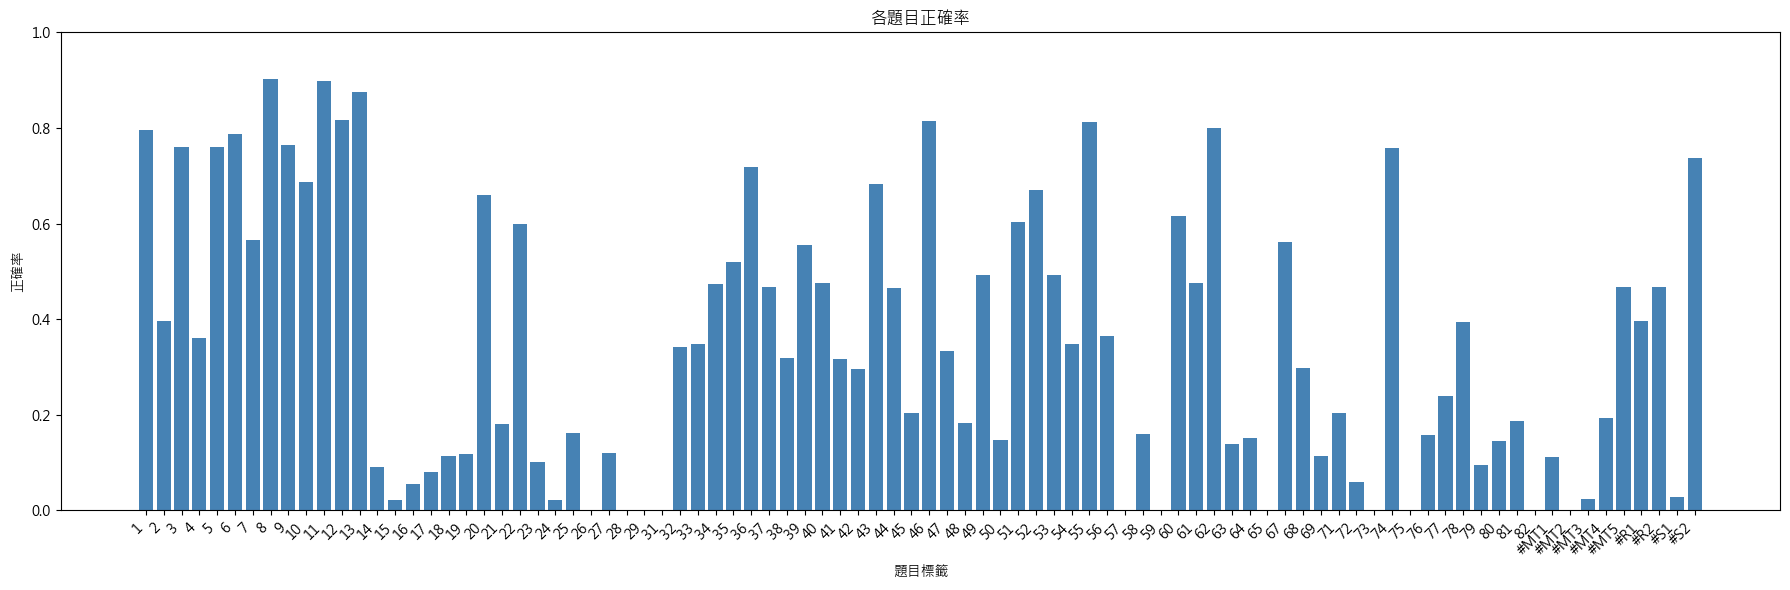

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# 假設你的最終結果 DataFrame 為 df_final，包含 "Label" 與 "Answer" 欄位

# 1. 計算每個 Label 的正確率
df_correctness = (
    df_final.groupby("Original_Label")["Final_Label"]
    .apply(lambda x: (x == "Yes").sum() / len(x))
    .reset_index(name="Accuracy")
)

# 2. 定義一個函數，檢查 Label 是否能轉換為數值
def is_numeric(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

# 3. 根據是否為數字，分為兩組
df_correctness["is_numeric"] = df_correctness["Original_Label"].apply(is_numeric)

# 對數字部分依照數值大小排序
df_numeric = df_correctness[df_correctness["is_numeric"]].copy()
df_numeric["Label_numeric"] = df_numeric["Original_Label"].astype(float)
df_numeric.sort_values("Label_numeric", inplace=True)

# 文字部分可以保留原有順序或依 Accuracy 排序
df_text = df_correctness[~df_correctness["is_numeric"]].copy()
# 若希望文字部分也依 Accuracy 排序，可以取消下行註解
# df_text.sort_values("Accuracy", inplace=True)

# 4. 合併數字與文字的部分（例如，先顯示數字，再顯示文字）
df_final_sorted = pd.concat([df_numeric, df_text])

# 5. 設定中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 或其他支援中文的字型
plt.rcParams['axes.unicode_minus'] = False

# 6. 繪製長條圖
plt.figure(figsize=(18, 6))
plt.bar(df_final_sorted["Original_Label"], df_final_sorted["Accuracy"], color='steelblue')

plt.xlabel("題目標籤")
plt.ylabel("正確率")
plt.title("各題目正確率")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()